## Import Libraries

In [145]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [146]:
df = pd.read_csv("./Higher player.csv")

In [147]:
df.shape

(4840, 19)

In [148]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [149]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [150]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [151]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [152]:
numeric_col = [col for col in df.columns if df[col].dtype != "object"]
categorical_col = [col for col in df.columns if df[col].dtype == "object"]

In [153]:
# for i in categorical_col:
#     print(df[i].value_counts())

In [154]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['sale_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['sale_price_category'].value_counts())

sale_price_category
Good_Price     2017
Cheap_Price    1603
High_Price     1220
Name: count, dtype: int64


In [155]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,70000000,High_Price
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,High_Price


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [156]:
categorical_col = ['team' , 'position']

In [157]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_col)

In [158]:
df.shape

(4840, 367)

In [159]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [160]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
highest_value          0.582366
appearance             0.494350
minutes played         0.378611
assists                0.238781
                         ...   
team_SV Ried          -0.083769
clean sheets          -0.092218
position_Goalkeeper   -0.113328
goals conceded        -0.121615
age                   -0.137774
Name: sale_price_category, Length: 367, dtype: float64

In [161]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['age', 'appearance', 'goals', 'assists', 'goals conceded',
       'minutes played', 'days_injured', 'games_injured', 'award',
       'highest_value', 'sale_price_category', 'team_Chelsea FC',
       'position_Goalkeeper'],
      dtype='object')

In [162]:
df = df[selected_features]

#### 4. Prepare train and test data

In [163]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [164]:
X.shape

(4840, 12)

## Buliding the Model

In [165]:
model = LogisticRegression()

## Train the Model

In [166]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

## Test the Model

In [167]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Interpretation of the Model

In [168]:
model.coef_

array([[ 0.97052066, -0.52590112,  0.0317169 , -0.16431588,  0.19737199,
        -0.36011959, -0.10066313, -0.02050058,  0.19765789, -7.7995718 ,
         0.05293903, -0.22934136],
       [ 0.22596159,  0.1793603 , -0.08880433, -0.04092309,  0.11327819,
        -0.19322272, -0.02217354, -0.02787645,  0.18346945,  1.79879682,
        -0.01343139, -0.13740763],
       [-1.19648225,  0.34654082,  0.05708743,  0.20523897, -0.31065019,
         0.55334231,  0.12283667,  0.04837703, -0.38112734,  6.00077498,
        -0.03950765,  0.36674899]])

In [169]:
print(model.intercept_) 

[-2.59158563  2.00951939  0.58206624]


## Evaluating the Model 

In [170]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

41.67

1. Accuracy

In [171]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test Accuracy' ,accuracy_test*100)

y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy' ,accuracy_train*100)

Test Accuracy 78.4090909090909
Train Accuracy 78.79648760330579


2. Precision

In [172]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print("Test Precision:" ,precision_test*100)

y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Precision:' ,precision_train*100)

Test Precision: 80.27692906639027
Train Precision: 80.51920075661081


3. Recall

In [173]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test Recall:" , recall_test*100)

y_pred_train = model.predict(X_train_scaled)
recall_train = precision_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,recall_train*100)

Test Recall: 79.13501602564102
Train Recall: 80.51920075661081


4. F1 Score

In [174]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print("Test F1 Score:" , f1_test*100)

y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print('Train Recall:' ,f1_train*100)

Test F1 Score: 79.39765341256226
Train Recall: 79.56477155490552


#### Predictions vs. Real Values

In [175]:
predictions = model.predict(X_test_scaled)

In [176]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

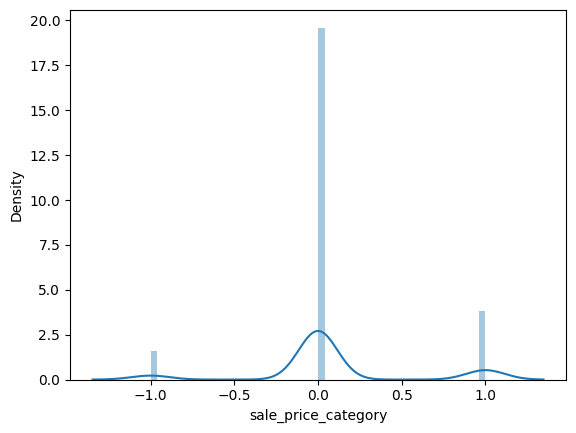

In [177]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

In [178]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[267,  45,   0],
       [ 96, 287,  17],
       [  0,  51, 205]], dtype=int64)